<a href="https://colab.research.google.com/github/papa-fololo/Repo1/blob/master/featureOptimisedRFbikedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
rentals = pd.read_csv("bikedata1.csv")

data = rentals

data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,01/01/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,01/02/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,01/03/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,01/04/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,01/05/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


In [ ]:

data['dteday'] = pd.to_datetime(data['dteday']).dt.date
data=data.set_index('dteday')
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
dteday,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  rentals     731 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 74.2+ KB


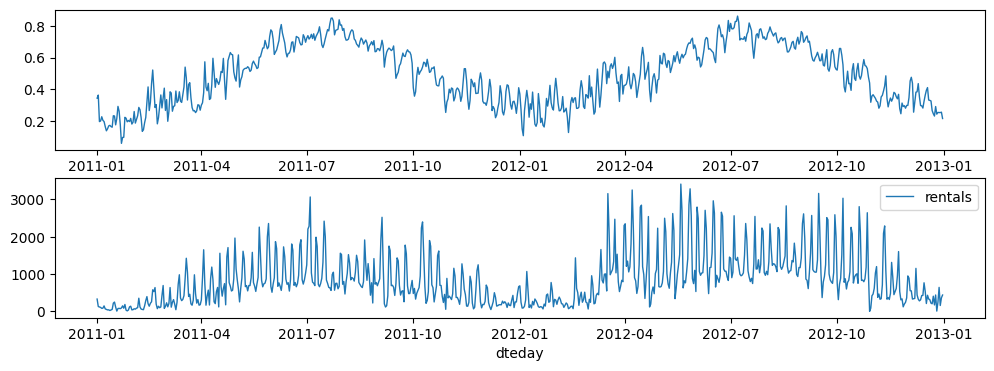

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12, 4))
data.temp.plot(ax=ax[0], label='temp', linewidth=1)
data.rentals.plot(ax=ax[1], label='rentals', linewidth=1)
#X_test.Close.plot(ax=ax, label='test', linewidth=1)
#plt.set_title('Temp normal')
plt.legend();

In [ ]:
# Introduce weekly time lag for exogenous features
lag = 7  # Weekly time lag
exogenous_cols = data[['workingday','temp']]
for col in exogenous_cols:
    data[f'{col}_lag{lag}'] = data[col].shift(lag)



# Create X and y test/train split where shuffle is set to False
#X = df_clean[['a', 'b', 'c', 'd', 'a_lag7', 'b_lag7', 'c_lag7', 'd_lag7']]
#y = df_clean['e']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
X = data[['workingday','temp','workingday_lag7', 'temp_lag7']]
y = data['rentals']

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle = False)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 511 rows
Test Set: 220 rows


In [ ]:
X_train.head(), y_train.head()

(            workingday      temp  workingday_lag7  temp_lag7
 dteday                                                      
 2011-01-01           0  0.344167              NaN        NaN
 2011-01-02           0  0.363478              NaN        NaN
 2011-01-03           1  0.196364              NaN        NaN
 2011-01-04           1  0.200000              NaN        NaN
 2011-01-05           1  0.226957              NaN        NaN,
 dteday
 2011-01-01    331
 2011-01-02    131
 2011-01-03    120
 2011-01-04    108
 2011-01-05     82
 Name: rentals, dtype: int64)

In [ ]:
y_train_N = y_train.iloc[7:]
y_train_N.head()


dteday
2011-01-08    68
2011-01-09    54
2011-01-10    41
2011-01-11    43
2011-01-12    25
Name: rentals, dtype: int64

In [ ]:
X_train_df = pd.DataFrame(data = X_train)
X_test_df = pd.DataFrame(data = X_test)
y_train_df = pd.DataFrame(data = y_train)
y_test_df = pd.DataFrame(data = y_test)

y_test_df.head()

,rentals
dteday,
2012-05-26,2855
2012-05-27,3283
2012-05-28,2557
2012-05-29,880
2012-05-30,745


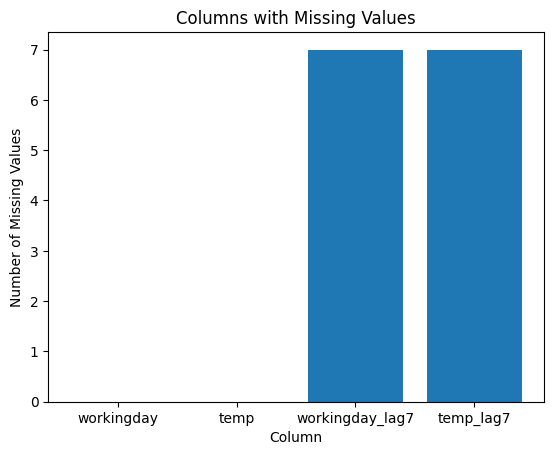

In [ ]:
X_train_N=X_train.dropna()
X_test_N=X_test.dropna()

missing = X_train.isnull()

# create a bar plot of missing values by column
plt.bar(missing.columns, missing.sum())
plt.title('Columns with Missing Values')
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.show()

In [ ]:
X_train_N.head()

,workingday,temp,workingday_lag7,temp_lag7
dteday,,,,
2011-01-08,0,0.165000,0.0,0.344167
2011-01-09,0,0.138333,0.0,0.363478
2011-01-10,1,0.150833,1.0,0.196364
2011-01-11,1,0.169091,1.0,0.200000
2011-01-12,1,0.172727,1.0,0.226957


In [ ]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np

model = RandomForestRegressor().fit(X_train_N, y_train_N)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test_N)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2model = r2_score(y_test, predictions)
print("R2:", r2model)


RandomForestRegressor() 

MSE: 224209.46642409088
RMSE: 473.5076202386725
R2: 0.5758564752816188


In [ ]:
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

MAE: 354.44168181818185


In [ ]:
y_test_df['RF'] = predictions

y_test_df.head()

,rentals,RF
dteday,,
2012-05-26,2855,1937.43
2012-05-27,3283,1981.80
2012-05-28,2557,1771.89
2012-05-29,880,887.27
2012-05-30,745,757.34


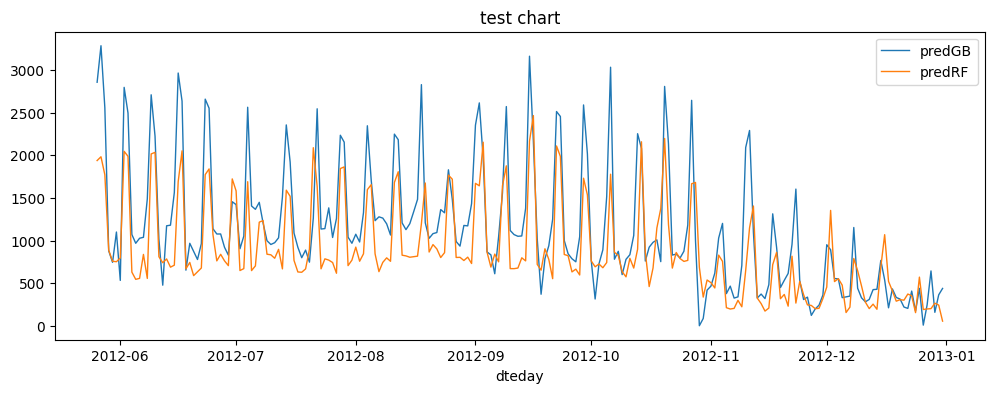

In [ ]:
#predictions1['Date/Time'] = predictions1['Date/Time'].dt.strftime('%Y-%m-%d')
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
#data.rentals.plot(ax=ax, label='train', linewidth=1)
#data.rentals.plot(ax=ax, label='actual', linewidth=1)
y_test_df.rentals.plot(ax=ax, label='predGB', linewidth=1)
y_test_df.RF.plot(ax=ax, label='predRF', linewidth=1)

ax.set_title('test chart')
ax.legend();

In [ ]:
# Use grid search to find the best hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [4, 8, 16]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_search.fit(X_train_N, y_train_N)

# Get the best model from the grid search
best_rf = grid_search.best_estimator_
model2 = best_rf

# Predict on the test dataset using the best hyperparameters
pred2 = best_rf.predict(X_test)


In [ ]:
y_test_df['RF2'] = pred2

y_test_df.head()

,rentals,RF,RF2
dteday,,,
2012-05-26,2855,1937.43,1922.413051
2012-05-27,3283,1981.80,1920.588642
2012-05-28,2557,1771.89,1892.978043
2012-05-29,880,887.27,758.058877
2012-05-30,745,757.34,755.764502


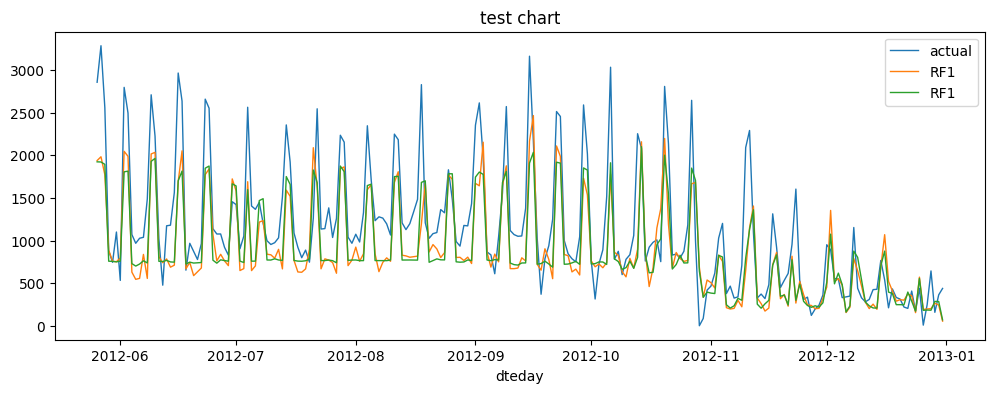

In [ ]:
#predictions1['Date/Time'] = predictions1['Date/Time'].dt.strftime('%Y-%m-%d')
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
#data.rentals.plot(ax=ax, label='train', linewidth=1)
#data.rentals.plot(ax=ax, label='actual', linewidth=1)
y_test_df.rentals.plot(ax=ax, label='actual', linewidth=1)
y_test_df.RF.plot(ax=ax, label='RF1', linewidth=1)
y_test_df.RF2.plot(ax=ax, label='RF1', linewidth=1)

ax.set_title('test chart')
ax.legend();

In [ ]:

mse2 = mean_squared_error(y_test, pred2)
print("MSE:", mse2)
rmse2 = np.sqrt(mse2)
print("RMSE:", rmse2)
r2model2 = r2_score(y_test, pred2)
print("R2:", r2model2)
mae2 = mean_absolute_error(y_test, pred2)
print("MAE:", mae2)

MSE: 206372.72937944788
RMSE: 454.28265361936053
R2: 0.6095987460262448
MAE: 342.530288291051


In [ ]:
mae2 = mean_absolute_error(y_test, pred2)
print("MAE:", mae2)

MAE: 342.530288291051


In [ ]:

print("MSE:", mse, mse2)

print("RMSE:", rmse,rmse2)

print("R2:", r2model, r2model2)

print("mae:", mae, mae2)

MSE: 224209.46642409088 206372.72937944788
RMSE: 473.5076202386725 454.28265361936053
R2: 0.5758564752816188 0.6095987460262448
mae: 354.44168181818185 342.530288291051


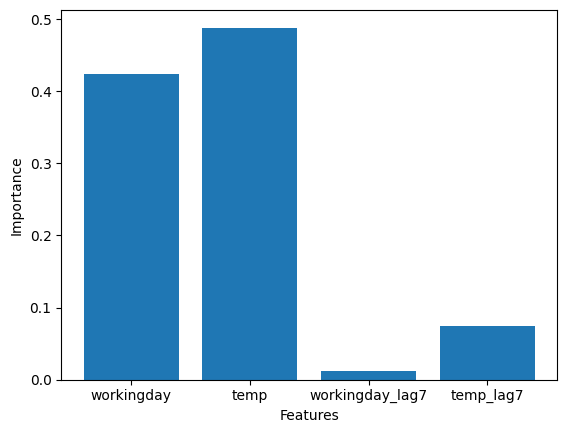

In [ ]:
# Plot the feature importance
feature_importance = model2.feature_importances_
plt.bar(X.columns, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()